In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import elasticite as el
import numpy as np
duration = el.get_default_args(el.EdgeGrid.render)['duration']

In [3]:
import sys
sys.path.append('..')
from scenario_line_fresnel import EdgeGrid
e = EdgeGrid(N_lame=25, grid_type='line')

In [4]:
e.lames.shape

(4, 31)

## sampling particles on the structure

In [5]:
struct = e.lames[:3, -e.struct_N:]
N_particles = e.struct_N * 2**8
particles = np.ones((5, N_particles))
for i, vec in enumerate(struct.T.tolist()):
    print(i, vec)
    N_particles_ = N_particles/e.struct_N
    x0, x1 = vec[0] - .5*e.struct_longueur*np.cos(vec[2]), vec[0] + .5*e.struct_longueur*np.cos(vec[2])
    y0, y1 = vec[1] - .5*e.struct_longueur*np.sin(vec[2]), vec[1] + .5*e.struct_longueur*np.sin(vec[2])
    particles[0, i*N_particles_:(i+1)*N_particles_] = np.linspace(x0, x1, N_particles_)
    particles[1, i*N_particles_:(i+1)*N_particles_] = np.linspace(y0, y1, N_particles_)
    

0 [-1.4488887394336025, 3.111771432346219, 3.4033920413889427]
1 [-3.5317048714782544, 1.364081184137463, 4.276056667386108]
2 [-3.853764727862665, -1.4626018975182205, 4.921828490624009]
3 [1.4488887394336025, 3.111771432346219, -0.2617993877991494]
4 [3.5317048714782544, 1.364081184137463, -1.1344640137963142]
5 [3.853764727862665, -1.4626018975182205, -1.780235837034216]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
particles

array([[ 0.        , -0.01136383, -0.02272767, ...,  3.54678923,
         3.54434321,  3.54189719],
       [ 3.5       ,  3.49695507,  3.49391014, ..., -2.90680806,
        -2.91831568, -2.9298233 ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


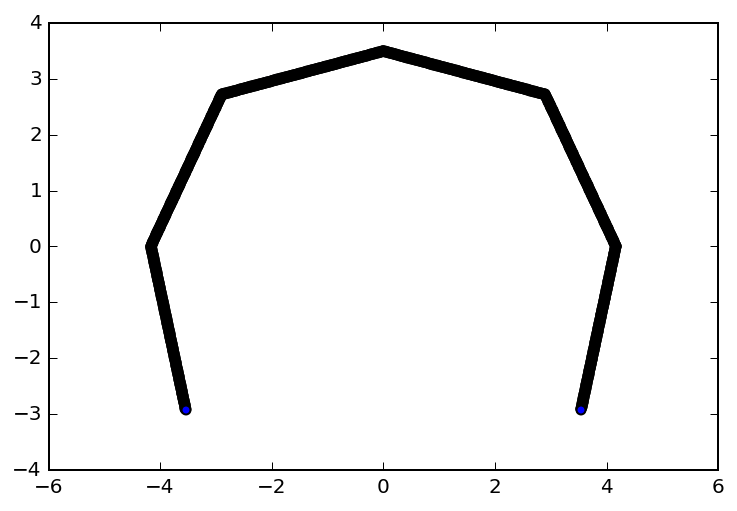

In [8]:
plt.scatter(particles[0,:], particles[1,:])

In [9]:
import MotionParticles as mp


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


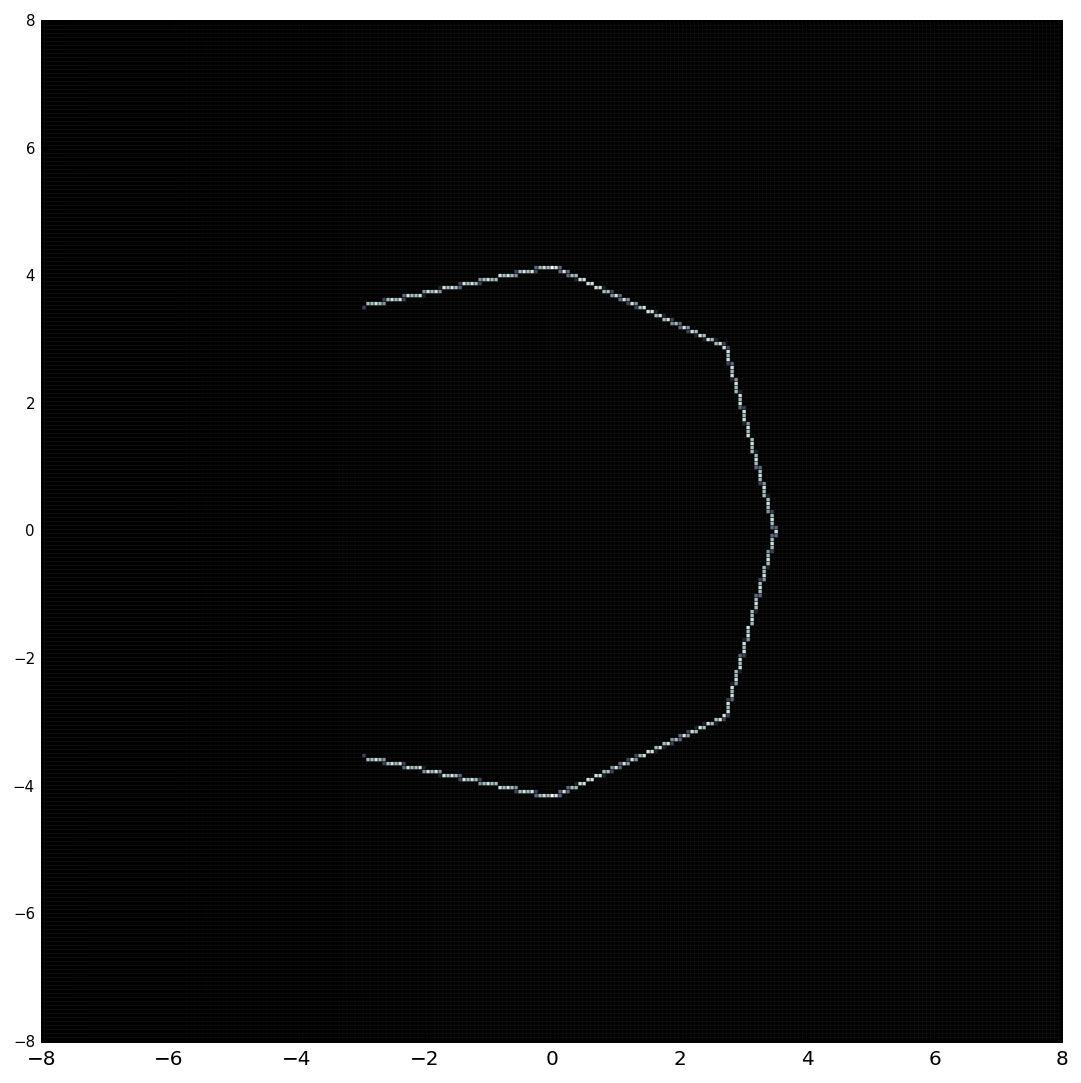

In [10]:
fig, ax = mp.spatial_readout(particles, N_X=256, N_Y=256, N_quant=256, hue=False, width=e.total_width*2)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


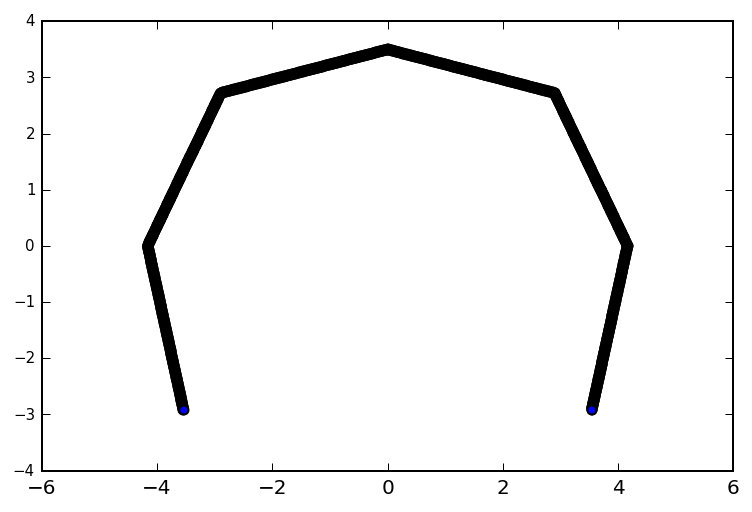

In [13]:
e.sample_structure()
plt.scatter(e.particles[0,:], e.particles[1,:])

## generating a trajectory

In [ ]:
import elasticite as el
import numpy as np

duration = el.get_default_args(el.EdgeGrid.render)['duration']
location = el.get_default_args(el.EdgeGrid.render)['location']


class EdgeGrid(el.EdgeGrid):
    def champ(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame
        tf = 2. #how many cycles in one period (duration)
        force = np.zeros_like(self.lames[2, :N_lame])
        damp = lambda t: 0.01 #* np.exp(np.cos(t / 6.) / 3.**2)
        xf = lambda t: location[0] - self.total_width/4.
        zf = lambda t: location[2] * (.5 + .45 * np.sin(2*np.pi*self.t*tf/duration))
        
        desired_angle = np.pi/2 + np.arctan2(self.lames[1, :N_lame]-zf(self.t), self.lames[0, :N_lame]-xf(self.t))
        self.lames[2, :N_lame] = np.mod(self.lames[2, :N_lame]-np.pi/2, np.pi) + np.pi/2
        force += np.mod(desired_angle-np.pi/2, np.pi) + np.pi/2- self.lames[2, :N_lame]
        force -= damp(self.t) * self.lames[3, :N_lame]/self.dt
        return 3. * force

e = EdgeGrid(N_lame=25, grid_type='line')


In [10]:
!git s
!git add 2015-10-27\ élasticité\ expansion.ipynb

?? ../.ipynb_checkpoints/
?? ../PLAN_PRINCIPE_PROTO/
?? ../Presentation-Dossier-Artistique/
?? ../TESTS_TRAME/
?? ../__temp_ipython__.png
?? ../files/elastic_fresnel.mp4
?? ../files/elastic_fresnel_gauche.mp4
?? ../files/elastic_fresnel_lateral.mp4
?? ../files/elastic_fresnel_pasapas.mp4
?? ../files/elastic_fresnel_rot.mp4
?? ../files/fresnel.mp4
?? "../files/grille_carr\303\251e.mp4"
?? ../files/lames_contraintes.mp4
?? ../files/lames_oscillantes.mp4
?? ../files/lames_oscillantes_fps5.mp4
?? "../notes-Laurent/2015-10-22_\303\251lasticit\303\251 LAMES-Dynamique_pdf.pdf"
?? .ipynb_checkpoints/
?? "2015-10-27 \303\251lasticit\303\251 expansion.ipynb"
?? __temp__.mp4
?? __temp_ipython__.png
?? anim.gif
?? ../screenshot.png
?? ../src/elasticite.egg-info/


In [11]:
!git commit -am' expansion - samples sur la structure'

[master 8bef010]  expansion - samples sur la structure
 1 file changed, 106 insertions(+)
 create mode 100644 "posts/2015-10-27 \303\251lasticit\303\251 expansion.ipynb"
